In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../environments/'); import gw
sys.path.insert(0,'../environments/'); import gridworld_plotting as gp
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec

import experiment as expt
from experiment import run_expt, run_mem_expt
#####

import torch
import time
import math
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
def run_expt(NUM_TRIALS, NUM_EVENTS, env, agent, data, **kwargs):
    print_freq = kwargs.get('printfreq', 0.1)

    get_samples = kwargs.get('get_samples', False)
    if get_samples:
        sample_observations = env.get_sample_obs()

    around_reward = kwargs.get('around_reward', True)
    start_radius = kwargs.get('radius', 5)

    start_locs = kwargs.get('room', None)

    t = time.time()
    data['start_count'] = np.zeros(env.shape)
    for trial in range(NUM_TRIALS):
        # reset environment, reinitialize agent in environment
        env.resetEnvironment(around_rwd=around_reward, radius=start_radius)

        if start_locs is not None:
            # st = np.random.choice(len(start_locs))
            st = start_locs[trial]
            env.set_state(env.twoD2oneD(st))

        loc1 = env.oneD2twoD(env.state)
        data['start_count'][loc1[0], loc1[1]] += 1
        # env.set_state(env.twoD2oneD((19,19)))
        # clear hidden layer cache if using lstm or gru cells
        agent.reinit_hid()
        reward_sum = 0

        for event in range(NUM_EVENTS):
            # get state observation
            observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))

            # pass observation through network
            # policy_, value_ = agent(observation)
            policy_, value_ = agent(observation)

            # select action from policy
            choice = agent.select_action(policy_, value_)
            action = env.action_list[choice][0]

            # take a step in the environment

            s_1d, reward, isdone = env.move(action)

            agent.saved_rewards.append(reward)
            reward_sum += reward
            ###optional
            # sar.append(env.state, action, reward) ## tracking oneD states
            if isdone:
                break

        p_loss, v_loss = agent.finish_trial()
        data['trial_length'].append(event)
        data['total_reward'].append(reward_sum)
        data['loss'][0].append(p_loss.item())
        data['loss'][1].append(v_loss.item())
        data['trials_run_to_date'] += 1
        if get_samples:
            pol_grid, val_grid = expt.sample_PV(sample_observations, env, agent)
            data['pol_tracking'].append(pol_grid)
            data['val_tracking'].append(val_grid)
            data['t'].append(trial)

        if trial == 0 or trial % int(print_freq * NUM_TRIALS) == 0 or trial == NUM_TRIALS - 1:
            print(f"{trial}: start at {loc1} {reward_sum} ({time.time() - t}s)")

            # num_states = len(env.useable)
            # cos_sim = np.zeros((num_states,num_states))

            # observations = env.get_sample_obs()
            # p,v,lin_acts4 = agent(torch.Tensor(observations[0]), lin_act=4)

            # LA4 = lin_acts4.data.numpy()

            # cs4 = cosine_similarity(LA4,LA4)

            # plt.figure(0)
            # plt.pcolor(cs4)
            # plt.show()
            t = time.time()

        if around_reward and trial > 0 and trial == int(
                NUM_TRIALS / 2):  # np.mean(data['trial_length'][-20:])< 2*start_radius:
            print(trial)
            # around_reward = False

In [12]:
reload(gw)
rerun = False

rows, columns = 10,10
env_type = None
penalty = -0.01 

NUM_TRIALS = 2000
NUM_EVENTS = 100


if not rerun:
    reward_location = (3,3)
    env = gw.GridWorld(rows=rows,cols=columns,
                       env_type=env_type,
                       rewards = {reward_location:1, (5,7):-2},#rewards={(int(rows/2),int(columns/2)):1},#
                       step_penalization=penalty,
                       rho=0.0,
                       rewarded_action = None)
    
    agent_params = expt.Parameters(env, use_EC = False)
    agent = ac.make_agent(agent_params)
    episodic_memory = ec.ep_mem(agent, 300)
    data = {'total_reward': [],
            'loss': [[],[]],
            'trial_length': [],
            'trials_run_to_date':0,
            'pol_tracking':[],
            'val_tracking':[],
            'ec_tracking': [],
            't': [],
            'mfcs':[]
           }

else:
    reward_location = (3,3)
    env = gw.GridWorld(rows=rows,cols=columns,
                       env_type=env_type,
                       rewards = {reward_location:1},#rewards={(int(rows/2),int(columns/2)):1},#
                       step_penalization=penalty,
                       rho=0.0,
                       rewarded_action = None)

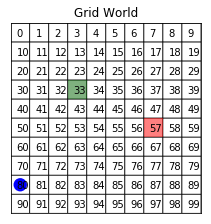

In [13]:
reload(gw)
fig = gw.plotWorld(env,current_state=True,scale=0.35, states=True) 
rooms = {'1': [], '2':[], '3':[], '4':[]}
for i in range(rows):
    for j in range(columns):
        if (i,j) in env.obstacles_list:
            pass
        else:
            if i < 5:
                if j <5:
                    rooms['1'].append((i,j))
                if j >5:
                    rooms['2'].append((i,j))
                if j ==5: 
                    rooms['1'].append((i,j))
                    rooms['2'].append((i,j))
            if i >5:
                if j <5:
                    rooms['3'].append((i,j))
                if j >5:
                    rooms['4'].append((i,j))
                if j ==5: 
                    rooms['3'].append((i,j))
                    rooms['4'].append((i,j))

            if i == 5:
                if j<5:
                    rooms['1'].append((i,j))
                    rooms['3'].append((i,j))
                if j>5: 
                    rooms['2'].append((i,j))
                    rooms['4'].append((i,j))

In [14]:
import random 
sample_observations = env.get_sample_obs()
print(int(NUM_TRIALS/len(env.useable)))
shuf = int(NUM_TRIALS/len(env.useable))*(env.useable)
random.shuffle(shuf)

run_expt(NUM_TRIALS, NUM_EVENTS, env, agent, data, get_samples=True, printfreq = 1, around_reward=True)
pol_grid, val_grid = expt.sample_PV(sample_observations, env,agent)
gp.plot_polmap(env, pol_grid, threshold = 0.25)
gp.plot_valmap(env, val_grid, v_range = [-0.1,1])

plt.imshow(data['start_count'])
plt.colorbar()

20
0: start at (4, 5) -4.979999999999984 (0.21470904350280762s)


KeyboardInterrupt: 

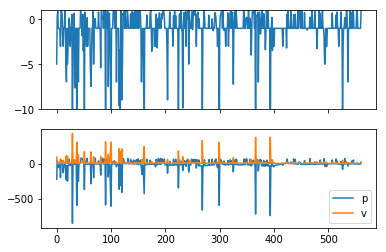

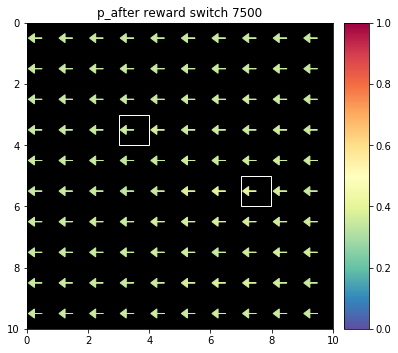

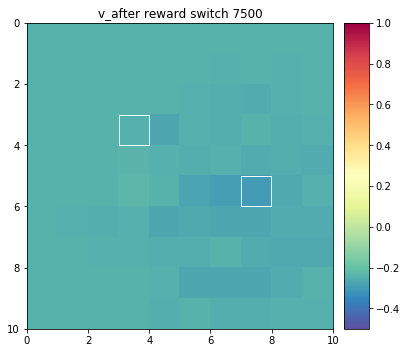

In [15]:
fig, ax = plt.subplots(2,1, sharex=True)
#ax[0].plot(data['trial_length'])
ax[0].plot(gp.running_mean(data['total_reward'],1))
ax[1].plot(data['loss'][0], label='p')
ax[1].plot(data['loss'][1], label='v')
ax[1].legend(loc=0)
ax[0].set_ylim([-10.,1])
plt.show()
sample_observations = env.get_sample_obs()
pol_grid, val_grid = expt.sample_PV(sample_observations, env,agent)
valmin = np.floor(np.min(val_grid))
valmax = np.ceil(np.max(val_grid))

gp.plot_polmap(env, pol_grid, threshold = 0.25, save=False, directory = './Blake Meeting/', title='p_after reward switch 7500', filetype='svg')
gp.plot_valmap(env, val_grid, v_range = [-0.5,1], save=False, directory = './Blake Meeting/', title='v_after reward switch 7500', filetype='svg')

In [ ]:
reload(ec)
episodic_memory = ec.ep_mem(agent, 300)
run_mem_expt(NUM_TRIALS, NUM_EVENTS, env, agent, episodic_memory, data, get_samples=True, printfreq=0.01)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

observations = env.get_sample_obs()
states = observations[1]
c = np.zeros(len(states))
for ind, x in enumerate(states):
    if x in rooms['1']:
        c[ind] = 1
    elif x in rooms['2']:
        c[ind] =2
    elif x in rooms['3']:
        c[ind] = 3
    elif x in rooms['4']:
        c[ind] = 4
p,v,lin_acts4 = agent(torch.Tensor(observations[0]), lin_act=4)

LA4 = lin_acts4.data.numpy()

k = pca.fit_transform(LA4)
plt.scatter(k[:,0],k[:,1],c=c, cmap =plt.cm.get_cmap('Accent_r',5))
plt.colorbar(ticks=range(4))
plt.show()

In [ ]:

num_states = len(env.useable)
cos_sim = np.zeros((num_states,num_states))

observations = env.get_sample_obs()
p,v,lin_acts4 = agent(torch.Tensor(observations[0]), lin_act=4)
p,v,lin_acts5 = agent(torch.Tensor(observations[0]), lin_act=5)

LA4 = lin_acts4.data.numpy()
LA5 = lin_acts5.data.numpy()

cs4 = cosine_similarity(LA4,LA4)
cs5 = cosine_similarity(LA5,LA5)

plt.figure(0)
plt.pcolor(cs4)
plt.figure(1)
plt.pcolor(cs5)
plt.show()

In [ ]:
from scipy.stats import pearsonr


index =  52
ind_state = env.oneD2twoD(index)
cos_map4 = cs4[index,:]

def euc(x,y):
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

index_map4 = np.zeros((rows,columns))
euc4 = [[],[]]
for ind, c in enumerate(cos_map4):
    coord = env.oneD2twoD(ind)
    index_map4[coord[0],coord[1]] = c
    euc4[0].append(euc(ind_state,coord))
    euc4[1].append(c)
    
cos_map5 = cs5[index,:]
euc5 = [[],[]]
index_map5 = np.zeros((rows,columns))
for ind, c in enumerate(cos_map5):
    coord = env.oneD2twoD(ind)
    index_map5[coord[0],coord[1]] = c
    
    euc5[0].append(euc(ind_state,coord))
    euc5[1].append(c)
    
gp.plot_valmap(env,index_map4, rwds= [env.oneD2twoD(index)],title='Similarity in Layer 4 Representations')
gp.plot_valmap(env,index_map5, rwds= [env.oneD2twoD(index)],title='Similarity in Layer 5 Representations')

plt.scatter(euc4[0],euc4[1],label = f'R={np.round(pearsonr(euc4[0], euc4[1])[0],4)}')
plt.scatter(euc5[0],euc5[1],label = f'R={np.round(pearsonr(euc5[0], euc5[1])[0],4)}')
plt.legend(loc=0)

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(data1, data2)

In [ ]:
recency_env = ec.calc_env(halfmax = 20)
mem_temp = 0.3
state = torch.Tensor([env.get_observation(agtlocation=(9,16))])
p_, v_, l_ = agent(state, lin_act=2)
lin_act = tuple(np.round(l_.data[0].numpy(), 4))
track = []

for i in range(0,sum(data['trial_length']),500):
    memory_policy = torch.from_numpy(episodic_memory.recall_mem(lin_act, 
                                                               i, 
                                                               env=recency_env, mem_temp=mem_temp))
    track.append(memory_policy.data.numpy())
print(env.action_list)
print(memory_policy)

In [ ]:
#mat = np.array(list[episodic_memory.cache_list.keys()])
true_key, sim = episodic_memory.cosine_sim(lin_act)
entry = episodic_memory.cache_list[true_key]

In [ ]:
for i in range(len(track[0])):
    plt.plot(track[i], label=env.action_list[i])
plt.xlim([0,10])
plt.legend(loc=0)

In [ ]:

#plt.savefig('./Blake Meeting/Total_reward.svg', format='svg')

In [ ]:
print(env.obstacles_list)

In [ ]:
data['env'] = env.shape

In [ ]:
import pickle

pickle.dump(data, open('../Blake Meeting/simple_network/test.p', 'wb'))

In [ ]:
savestring = f'../data/outputs/gridworld/4rooms{rows}{columns}.pt'
ac.torch.save(agent,savestring)

In [ ]:
reload(ac)
for i in range(0,1):
    abcd, efgh = ac.mem_snapshot(env, 
                           episodic_memory, 
                           trial_timestamp = 3, 
                           decay           = ec.calc_env(halfmax = 2000), 
                           mem_temp        = 1,
                                get_vals=True)#agent_params['mem_temp'])
    gp.plot_polmap(env, abcd,save=False, threshold = 0.22, title='ec_pol_new_rwd')

In [ ]:
pol_grid = np.zeros(env.shape, dtype=[('D', 'f8'), ('U', 'f8'), ('R', 'f8'), ('L', 'f8'), ('J', 'f8'), ('P', 'f8')])
for i in range(rows):
    for j in range(columns):
        obs = torch.Tensor(np.expand_dims(env.get_observation(agtlocation= (i,j)), axis=0))
        p,v, lin_act = agent(obs, lin_act=2)
        h = tuple(np.round(lin_act.data[0].numpy(),4))
        h_mem, sim = episodic_memory.cosine_sim(h)
        
        infos = episodic_memory.cache_list[h_mem]
        
        
        memory = infos[0]
        t = infos[1]
        state = infos[2]
        
        decay = 20
        p_val = np.round( 1/ np.cosh((len(data['trial_length'])-t)/decay), 8)
        
        p_prime = np.nan_to_num(memory[:,0])
        policy = tuple(ec.softmax(sim*p_prime))
        print(f'({i},{j}) {sim} with {state}:\n{p_prime}\n{policy}\n======')
        if sim < 0.8:
            pol_grid[i,j] = tuple(ec.softmax([1,1,1,1,1,1]))
        else:
            pol_grid[i,j] = policy

In [ ]:
print(len(data['trial_length']))
gp.plot_polmap(env, pol_grid)

In [ ]:
i,j = (10,2)
print(pol_grid[i,j])

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2)
for x in env.action_list:
    gp.plot_valmap(env, efgh[x[0]], v_range = [0,1], title=x)


In [ ]:
for x in list(episodic_memory.cache_list.values()):
    print(f'=====\n{x[2]}\n{x[0]}')

In [ ]:
a = np.zeros((3,6))

In [ ]:
print(env.state, oneD2twoD(env.state, env.shape))
fig = plotWorld(env,current_state=False)

num_steps = 10
moves = True
if moves:
    for _ in range(num_steps):
        if _ == 0:
            action_choice = ""
        start_at = oneD2twoD(env.state, env.shape)
        # draw state
        agent_y, agent_x = oneD2twoD(env.state, env.shape)
        agent_dot = plt.Circle((agent_x + .5, agent_y + .5), 0.35, fc='b')
        fig.gca().add_artist(agent_dot)

        # select action
        action_choice = random_policy(env)
        env.move(action_choice)

        print(f"{start_at}:{action_choice} --> {oneD2twoD(env.state, env.shape)}")
        text = plt.gcf().text(0.1, 0.9, f'Agent Chooses: {action_choice}', fontsize=14)

        plt.pause(1)
        plt.draw()
        dx1, dy1, head_w, head_l = make_arrows(env.action_dict[action_choice])
        if action_choice == 'P':
            arrow = plt.text(agent_x+0.49, agent_y+0.6, "*", {'color': 'white', 'fontsize': 24, 'ha': 'center', 'va': 'center'})
        else:
            arrow = plt.arrow(agent_x+0.5, agent_y+0.5, dx1, dy1, head_width=0.3, head_length=0.2, color="cyan")


        plt.pause(.5)
        plt.draw()

        if _ < num_steps-1:
            agent_dot.remove()
            arrow.remove()
            text.remove()
plt.show()